# Unsupervised Learning Capstone
## Email Novelty Detection
###  Introduction

The purpose of this capstone is to identify the most unique emails based on text classification and Natural Language Processing using spaCy.  

### Data

The data used for this project is the Enron email corpus.  We will train this model and try to identify unique emails out of the data set.  Specifically, we look at the sent emails from each user.  This way, the texts can be labeled to be identified to unique users.

You can download the data from here:  https://www.kaggle.com/wcukierski/enron-email-dataset/data

I didn't do that, and I ultimately did it the hard way by downloading the originals and traversing the path.  The data in the link from Kaggle is already formatted for you, which would've made this whole thing a lot easier, but you live and learn.

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
import re
import glob
import email
from nltk.corpus import stopwords
import spacy
import nltk

In [2]:
# Utility function to clean text.
def text_cleaner(text):  
    text = re.sub(r'-',' ',text)
    text = re.sub("\n", " ", text)
    text = re.sub("~.*", "", text)
    text = re.sub('[^A-Za-z .-]+', ' ', text)
    text = re.sub('\.', '', text)
    # Get rid of extra whitespace.
    text = ' '.join(text.split())
    text = re.sub("Get Your Private, Free E mail from MSN Hotmail at", "", text)    
    text = re.sub("Forwarded by", "", text)
    return text

In [3]:
# Here I am limiting this to 1000 emails.  NLP is extremely memory intensive and I could not run this on my computer without
# memory errors for the entire body of emails.

i = 0

directory = "C:\\Users\\kim\\Downloads\\enron_mail\\maildir"

fileList = [os.path.normcase(f)
                for f in os.listdir(directory)] 

stopWords = set(stopwords.words('english'))

records = []

for f in fileList:
    sent_emails = "C:\\Users\\kim\\Downloads\\enron_mail\\maildir\\{0}\\sent".format(f) 
    try:
    
        for f1 in os.listdir(sent_emails):
            if i == 1000:
                break
            f1 = "C:\\Users\\kim\\Downloads\\enron_mail\\maildir\\{0}\\sent\\{1}".format(f, f1) 
            my_file = open(f1, 'r')
            text = my_file.read()
            
            b = email.message_from_string(text)
            if b.is_multipart():
                for payload in b.get_payload():
                    # if payload.is_multipart(): ...
                    text = payload.get_payload()
            else:
                text = b.get_payload()
            text = text_cleaner(text)
            i += 1
            record = [f, text]
            records.append(record)
    except FileNotFoundError:
        continue

In [4]:
df = pd.DataFrame(records, columns=['user','text'])

In [5]:
df.head()

,user,text
0,allen-p,Phillip K Allen HOU ECT on PM Lucy Gonzalez s...
1,allen-p,Phillip K Allen HOU ECT on PM Enron admin FSD...
2,allen-p,Larry Just a note to touch base on the sagewoo...
3,allen-p,Ina I scheduled a meeting with Jean Mrha tomor...
4,allen-p,Phillip K Allen HOU ECT on AM Jeff Richter AM...


In [6]:
# Using SpaCy to turn each email into a SpaCy doc object and store it in a dataframe
# Once it's in a doc object format
nlp = spacy.load('en') 
df['doc'] = df['text'].apply(lambda x: nlp(x))
df['word_count'] = df['doc'].apply(lambda x: len(x))

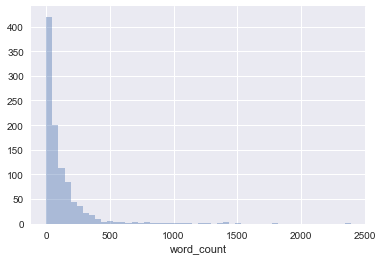

In [7]:
sns.distplot(df.word_count, kde=False)

In [8]:
df = df[df['word_count']>=20]

In [9]:
df.describe()

,word_count
count,783.000000
mean,162.688378
std,227.672253
min,20.000000
25%,47.000000
50%,90.000000
75%,184.000000
max,2391.000000


In [10]:
all_documents = []

for index, row in df.iterrows():
    doc = row['doc']
    for index2, row2 in df.iterrows():
        doc2 = row2['doc']
        similarity = doc.similarity(doc2)
        all_documents.append([row['user'], row['text'], similarity, row2['user'], row2['text']])  

In [11]:
all_documents = pd.DataFrame(all_documents, columns=['user','text','similarity', 'user2', 'text2'])

In [12]:
all_documents.sort_values(by='similarity')

,user,text,similarity,user2,text2
190491,allen-p,Here is the buyout spreadsheet again with a sl...,0.143255,allen-p,Phillip K Allen HOU ECT on AM To Phillip K Al...
174069,allen-p,Phillip K Allen HOU ECT on AM To Phillip K Al...,0.143255,allen-p,Here is the buyout spreadsheet again with a sl...
237492,allen-p,Phillip K Allen HOU ECT on AM Susan J Mara EN...,0.150850,allen-p,Here is the buyout spreadsheet again with a sl...
190572,allen-p,Here is the buyout spreadsheet again with a sl...,0.150850,allen-p,Phillip K Allen HOU ECT on AM Susan J Mara EN...
237993,allen-p,Phillip K Allen HOU ECT on AM Susan J Mara EN...,0.161214,arnold-j,your guys are probably seeing this as well but...
582855,arnold-j,your guys are probably seeing this as well but...,0.161214,allen-p,Phillip K Allen HOU ECT on AM Susan J Mara EN...
229380,allen-p,Phillip K Allen HOU ECT on AM Robert Neustaed...,0.161904,arnold-j,your guys are probably seeing this as well but...
582844,arnold-j,your guys are probably seeing this as well but...,0.161904,allen-p,Phillip K Allen HOU ECT on AM Robert Neustaed...
582774,arnold-j,your guys are probably seeing this as well but...,0.162202,allen-p,Phillip K Allen HOU ECT on AM To Phillip K Al...
174570,allen-p,Phillip K Allen HOU ECT on AM To Phillip K Al...,0.162202,arnold-j,your guys are probably seeing this as well but...


The two texts below are the least similar.  This finds the most novel, unique emails in the body of emails compared to each other.

In [13]:
all_documents.iloc[190491]['text']

'Here is the buyout spreadsheet again with a slight tweak in the format The summary presents the numbers as only in concessions'

In [14]:
all_documents.iloc[190491]['text2']

' Phillip K Allen HOU ECT on AM To Phillip K Allen HOU ECT ECT cc Subject Current Gas Desk List Hope this helps This is the current gas desk list that I have in my personal address book Call me with any questions Erika GROUP East Desk Basics Group name East Desk Group type Multi purpose Description Members Matthew B Fleming HOU EES James R Barker HOU EES Barend VanderHorst HOU EES Jay Blaine HOU EES Paul Tate HOU EES Alain Diza HOU EES Rhonda Smith HOU EES Christina Bangle HOU EES Sherry Pendegraft HOU EES Marde L Driscoll HOU EES Daniel Salinas HOU EES Sharon Hausinger HOU EES Joshua Bray HOU EES James Wiltfong HOU EES Owners Erika Dupre HOU EES Administrators Erika Dupre HOU EES Foreign directory sync allowed Yes GROUP West Desk Basics Group name West Desk Group type Multi purpose Description Members Jesus Guerra HOU EES Monica Roberts HOU EES Laura R Arnold HOU EES Amanda Boettcher HOU EES C Kyle Griffin HOU EES Jess Hewitt HOU EES Artemio Muniz HOU EES Eugene Zeitz HOU EES Brandon 

In [15]:
all_documents.iloc[190491]['similarity']

0.14325515481245796

In [16]:
result = all_documents.groupby(['text']).similarity.mean()

In [17]:
result[result < 0.2]

Series([], Name: similarity, dtype: float64)

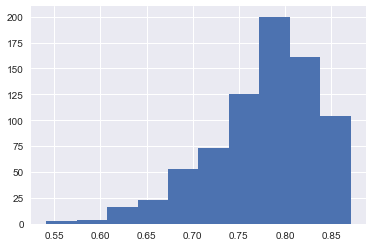

In [18]:
pd.Series(result.values).hist()

In [19]:
result_df = pd.DataFrame(result)
result_df.head()

,similarity
text,
John Arnold HOU ECT on AM Eric Thode ENRON AM To John Arnold HOU ECT ECT Tim Belden HOU ECT ECT cc Subject Electricity and Natural Gas hedging John and Tim I believe this one is for both of you Thanks Eric Eric Thode Corp Enron on AM LisaMFeener enroncom on AM To ericthode enroncom cc Subject Electricity hedging Lisa M Feener ENRON DEVELOPMENT on AM Holbrook Doug holbrookd portseattleorg on AM To lfeener enroncom lfeener enroncom cc Subject Electricity hedging I work for the Airport Authority for Seattle Tacoma International Airport in Seattle Washington and I am responsible for Managing the Utilities We are interested in hedging our Electricity and Natural Gas supplies Can I get some information on Enron s services in this area Douglas C Holbrook Manager Business Utilities Management Port of Seattle Seattle Tacoma International Airport PO Box Seattle WA Phone Fax holbrookd portseattleorg,0.747955
John Arnold HOU ECT on AM From Jason R Williams ENRON enronXgate on AM To Phillip K Allen HOU ECT ECT Scott Neal HOU ECT ECT Hunter S Shively ENRON enronXgate Thomas A Martin ENRON enronXgate John Arnold HOU ECT ECT cc William S Bradford ENRON enronXgate Tanya Rohauer ENRON enronXgate Russell Diamond ENRON enronXgate Subject PG E Energy Trading Phillip Scott Hunter Tom and John Just to reiterate the new trading guidelines on PG E Energy Trading Both financial and physical trading are approved with a maximum tenor of months Approved entities are PG E Energy Trading Gas Corporation PG E Energy Trading Canada Corporation NO OTHER PG E ENTITIES ARE APPROVED FOR TRADING Both EOL and OTC transactions are OK Please call Credit ext with details on every OTC transaction We need to track all new positions with PG E Energy Trading on an ongoing basis Please ask the traders and originators on your desks to notify us with the details on any new transactions immediately upon execution For large transactions greater than contracts day or BCF total please call for approval before transacting Thanks for your assistance please call me ext or Russell Diamond ext if you have any questions Jay,0.810711
John Arnold HOU ECT on AM From Margaret Allen ENRON on AM To John Arnold HOU ECT ECT cc Subject Commercials So what did you think Don t lie or stretch the truth either you won t hurt my feelings I promise By the way by the time I arrived home it was completely dark so I went for a three mile run this morning Not fun but I m definitely awake right now BUT it s all your fault I couldn t go last nighthe he Trade well MSA,0.795189
John Arnold HOU ECT on AM Mark Sagel msagel homecom on PM To John Arnold jarnold enroncom cc Subject natural update Latest comments FYI ng doc,0.729986
John Arnold HOU ECT on AM Matthew Arnold AM To John Arnold HOU ECT ECT cc Subject Re I m in John Arnold AM To Matthew Arnold HOU ECT ECT cc Subject lyle lovett national anthem nolan ryan first pitch dwight gooden first real pitch,0.753284


In [20]:
result_df = result_df.reset_index()
result_df.head()

,text,similarity
0,John Arnold HOU ECT on AM Eric Thode ENRON AM...,0.747955
1,John Arnold HOU ECT on AM From Jason R Willia...,0.810711
2,John Arnold HOU ECT on AM From Margaret Allen...,0.795189
3,John Arnold HOU ECT on AM Mark Sagel msagel h...,0.729986
4,John Arnold HOU ECT on AM Matthew Arnold AM T...,0.753284


In [21]:
final = result_df.sort_values(by='similarity')

The most unique email by least average similarity across all documents:

In [22]:
final.iloc[0].text

'options Either we leave from work and you watch me get a haircut for minutes or I pick you up around'

In [23]:
final.iloc[0].similarity

0.54136354786796237

### Conclusion and Further Work
Using SpaCy makes document comparison very easy.  Using this to find outliers in text could be used in the field of CyberSecurity to compare users to themselves.  Once you compare users to themselves, you would have a baseline of thier language.  A very unique and also very negative text could be an indicator that a user is disgruntled.  